In [1]:
import jax

jax.config.update("jax_compilation_cache_dir", "/cluster/scratch/mpundir/jax-cache")
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_platforms", "cpu")
import numpy as np
import functools

In [2]:
import matplotlib.pyplot as plt
from skimage.morphology import disk, rectangle, ellipse
import itertools

In [3]:
import sys
sys.path.append('../fft_helpers/')

from projection_operators import compute_Ghat_4_2
import tensor_operators as tensor
from fft_operators import laplacian_operator, gradient_operator
from custom_solvers import conjugate_gradient

## constructing an RVE with an inclusion

- inclusion = 1
- solid = 0


We construct the RVE with an volume fraction of 0.7 %

In [66]:
volume_fraction_percentage= 0.007

In [67]:
length = 0.1
H, L = (255, 255)

dx = length/H
dy = length/L

Hmid = int(H / 2)
Lmid = int(L / 2)
vol_inclusion = volume_fraction_percentage*(length*length)
r = int(np.sqrt(vol_inclusion/np.pi)/dx) + 1 # Since the rounding off leads to smaller fraction therefore we add 1. 



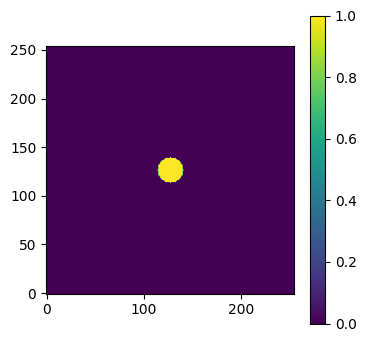

In [68]:
structure = np.zeros((H, L))
structure[Hmid-r: Hmid+1+r, Lmid-r:Lmid+1+r] += disk(r)

plt.figure(figsize=(4, 4))
cb = plt.imshow(structure, origin="lower")
plt.colorbar(cb)
plt.show()

In [69]:
ndim = len(structure.shape)
N = structure.shape[0]
shape = [
    N,
] * ndim

In [70]:
# identity tensor (single tensor)
i = jnp.eye(ndim)

# identity tensors (grid)
I2 = jnp.einsum(
    "ij,xy",
    i,
    jnp.ones(
        [
            N,
        ]
        * ndim
    ),
)
I = jnp.einsum(
    "ij,xy",
    i,
    jnp.ones(
        [
            N,
        ]
        * ndim
    ),
)
I4 = jnp.einsum(
    "ijkl,xy->ijklxy",
    jnp.einsum("il,jk", i, i),
    jnp.ones(
        [
            N,
        ]
        * ndim
    ),
)
I4rt = jnp.einsum(
    "ijkl,xy->ijklxy",
    jnp.einsum("ik,jl", i, i),
    jnp.ones(
        [
            N,
        ]
        * ndim
    ),
)


I4s = (I4 + I4rt) / 2.0
II = tensor.dyad22(I, I)
I4d = I4s - II / 3.0

## material parameters

In [71]:
# material parameters + function to convert to grid of scalars
@functools.partial(jax.jit, static_argnames=['inclusion', 'solid'])
def param(X, inclusion, solid):
    return inclusion*jnp.ones_like(X)*(X) + solid*jnp.ones_like(X)*(1-X)

In [72]:
# material parameters
# lames constant
lambda_modulus = {"solid": 2.0, "inclusion": 10}
shear_modulus = {"solid": 1.0, "inclusion": 5}

bulk_modulus = {}
bulk_modulus["solid"] = lambda_modulus["solid"] + 2 * shear_modulus["solid"] / 3
bulk_modulus["inclusion"] = lambda_modulus["inclusion"] + 2 * shear_modulus["inclusion"] / 3

In [73]:
λ0 = param(
    structure, inclusion=lambda_modulus["inclusion"], solid=lambda_modulus["solid"]
)  # lame parameter
μ0 = param(
    structure, inclusion=shear_modulus["inclusion"], solid=shear_modulus["solid"]
)  # lame parameter
K0 = param(structure, inclusion=bulk_modulus["inclusion"], solid=bulk_modulus["solid"])

## linear elastic constituive relation

Now, we define the stress-strain relationship, for this we directly derive the `stress` function by autodifferentiating the `strain energy` expression.

$$\psi = \dfrac{1}{2}(\text{tr}(\varepsilon_{ii})^2 + \mu \text{tr}(\varepsilon_{ij}\varepsilon_{jk} )$$
$$\sigma_{ij} = \dfrac{\partial \psi}{\partial \varepsilon_{ij}}$$

For FFT scheme, we define the above strain expression for each grid point ($x,y$)

$$\psi_{xy} = \dfrac{1}{2}(\text{tr}(\varepsilon_{iixy})^2 + \mu \text{tr}(\varepsilon_{ijxy}\varepsilon_{jkxy} ) $$
$$\sigma_{ijxy} = \dfrac{\partial \psi_{xy}}{\partial \varepsilon_{ijxy}}$$


In [74]:
@jax.jit
def strain_energy(eps):
    eps_sym = 0.5*(eps + tensor.trans2(eps))
    energy = 0.5 * jnp.multiply(λ0, tensor.trace2(eps_sym)**2) + jnp.multiply(μ0, tensor.trace2(tensor.dot22(eps_sym, eps_sym)))
    return energy.sum()


sigma = jax.jit(jax.jacrev(strain_energy))

## fft helpers and operators

In [75]:
# (inverse) Fourier transform (for each tensor component in each direction)
@jax.jit
def fft(x):
    return jnp.fft.fftshift(jnp.fft.fftn(jnp.fft.ifftshift(x), [N, N]))


@jax.jit
def ifft(x):
    return jnp.fft.fftshift(jnp.fft.ifftn(jnp.fft.ifftshift(x), [N, N]))

Projection tensor

In [119]:
Ghat4_2 = compute_Ghat_4_2(NN=(N,) * ndim, operator="rotated", length=length)

In [120]:
# functions for the projection 'G', and the product 'G : K : eps'
@jax.jit
def G(A2):
    return  jnp.real( ifft( tensor.ddot42(Ghat4_2,fft(A2)) ) ).reshape(-1)

@jax.jit
def G_K_deps(depsm, additionals):
    depsm = depsm.reshape(ndim,ndim,N,N)
    return G(sigma(depsm))

In [121]:
@jax.jit
def solve_elasticity(state, n):
    dF, b, F, Fn = state

    error = jnp.linalg.norm(dF)/Fn
    jax.debug.print('residual={}', error)

    def true_fun(state):
        dF, b, F, Fn = state

        dF, iiter = conjugate_gradient(
                atol=1e-10, 
                A = G_K_deps,
                b = b,
                additional=None
        )                                   # solve linear system using CG

        dF     = dF.reshape(ndim,ndim,N,N)
        F      = jax.lax.add(F, dF)         # update DOFs (array -> tensor.grid)
        P      = sigma(F)            # new residual stress
        b      = -G_K_deps(F, None)        # compute residual

        return (dF,  b, F, Fn)

    def false_fun(state):
        return state

    return jax.lax.cond(error > 1e-10, true_fun, false_fun, state), n

## testing elastic subproblem for a loaded state

In [122]:
sig      = jnp.zeros([ndim,ndim,N,N])
eps      = jnp.zeros([ndim,ndim,N,N])


deps      = jnp.zeros([ndim,ndim,N,N])
deps      = deps.at[0, 0].set(1e-3)
deps      = deps.at[1, 1].set(1e-1)

# initial residual: distribute "DE" over grid using "K4"
b        = -G_K_deps(deps, None)
eps      = jax.lax.add(eps, deps) 
En       = jnp.linalg.norm(eps)

In [123]:
state = (deps, b, eps, En)
state = jax.device_put(state)

In [124]:
import timeit
import tracemalloc

In [125]:
start_time = timeit.default_timer()
# starting the monitoring
tracemalloc.start()
final_state, xs = jax.lax.scan(solve_elasticity, 
                               init=state, 
                               xs=jnp.arange(0, 20))
# displaying the memory
print(tracemalloc.get_traced_memory())
final_time = timeit.default_timer()

# stopping the library
tracemalloc.stop()

print(final_time-start_time)

residual=1.0
residual=0.10137127610638182
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
(428118, 33731881)
2.0350411469698884


In [127]:
sig = sigma(final_state[2])
sig_xy = sig.at[0, 1].get()

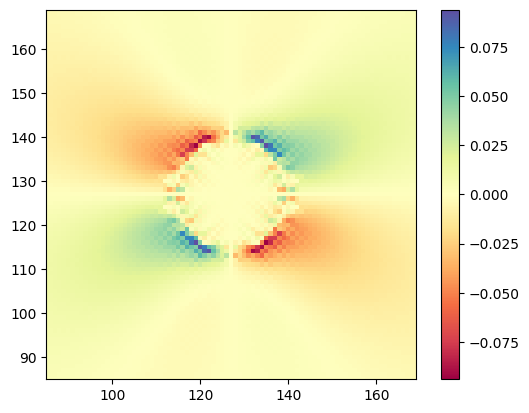

In [128]:
dx = length / N
N_inset = int(length / 6 / dx)

plt.imshow(sig_xy, origin="lower", cmap="Spectral")
plt.xlim(int(N / 2) - N_inset, int(N / 2) + N_inset)
plt.ylim(int(N / 2) - N_inset, int(N / 2) + N_inset)


plt.colorbar()

In [86]:
@jax.jit
def local_constitutive_update(macro_strain):

    # ----------------------------- NEWTON ITERATIONS -----------------------------
    # initialize stress and strain tensor                         [grid of tensors]
    eps      = jnp.zeros([ndim,ndim,N,N])
    # set macroscopic loading
    DE = jnp.zeros([ndim,ndim,N,N])
    DE = DE.at[0, 0].set(macro_strain[0])
    DE = DE.at[1, 1].set(macro_strain[1])
    DE = DE.at[0, 1].set(macro_strain[2]/2.)
    DE = DE.at[1, 0].set(macro_strain[2]/2.)

    # initial residual: distribute "DE" over grid using "K4"
    b        = -G_K_deps(DE, None)
    eps      = jax.lax.add(eps, DE) 
    En       = jnp.linalg.norm(eps)

    state = (DE, b, eps, En)
    initial_state = jax.device_put(state)

    final_state, xs = jax.lax.scan(solve_elasticity, 
                               init=initial_state, 
                               xs=jnp.arange(0, 20))
    
    DE, b, eps, En = final_state
    sig = sigma(eps)

    # get the macro stress
    macro_sigma = jnp.array([jnp.sum(sig.at[0, 0].get()*dx*dy), 
                             jnp.sum(sig.at[1, 1].get()*dx*dy), 
                             0.5*(jnp.sum(sig.at[1, 0].get()*dx*dy) + jnp.sum(sig.at[0, 1].get()*dx*dy))])
    macro_sigma = macro_sigma/length**2
    
    return macro_sigma, (macro_sigma, sig, eps)

In [87]:
tangent_operator_and_state = jax.jit(jax.jacfwd(
    local_constitutive_update, argnums=0, has_aux=True
))

In [88]:
deps = jnp.array([1.2, 1., 1])

In [89]:
start_time = timeit.default_timer()
# starting the monitoring
tracemalloc.start()
tangent, state = tangent_operator_and_state(deps)

# displaying the memory
print(tracemalloc.get_traced_memory())
final_time = timeit.default_timer()

# stopping the library
tracemalloc.stop()

print(final_time-start_time)

residual=1.0
residual=0.09815951857225792
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
residual=0.0
(1569125, 34869806)
6.298842019983567


In [90]:
tangent

Array([[ 4.03424410e+00,  2.01513204e+00, -6.14480052e-16],
       [ 2.01513204e+00,  4.03424410e+00,  9.53674395e-16],
       [-3.00622581e-15,  2.65781469e-15,  1.00930553e+00]],      dtype=float64)

The solution matches the Eshelby's analytical solution. Not exactly, but same result is also obtained by Gokuzum and Kiep. 

In [29]:
6/4

1.5

Roughly a speed up of 1.5 speedup